## Interpolación de valores faltantes

Primero cargamos la información y limpiamos los datos, así ocmo calcular las variables necesarias. 

In [37]:
import pickle
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import logging
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

ruta_guardado = r"C:\Users\mario\Desktop\MasterCienciadeDatos\TFM\TFM_MarioSoto\src\data_lake\PKL\dfs_final.pkl"

In [38]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [39]:
with open(ruta_guardado, 'rb') as f:
    dfs_final = pickle.load(f)

In [40]:
dfs = dfs_final

In [41]:
athletes_df = dfs['athletes_df']
athletes_events_df = dfs['athletes_events_df']
athletes_time_df = dfs['athletes_time_df']

issues_df = dfs['issues_df']
issues_events_df = dfs['issues_events_df']
issues_data_df = dfs['issues_data_df']
issues_times_df = dfs['issues_times_df']

In [42]:
athletes_events_df[['race_id', 'event_id']].drop_duplicates()

,race_id,event_id
0,b228b93e-2a15-4123-baf9-ca0915165c6a,Mitja
31679,78a14be0-36cc-4ce4-bb5a-b81744a7390e,Stage 1
31680,78a14be0-36cc-4ce4-bb5a-b81744a7390e,Stage 2
31681,78a14be0-36cc-4ce4-bb5a-b81744a7390e,Stage 3
31682,78a14be0-36cc-4ce4-bb5a-b81744a7390e,Stage 4
31683,78a14be0-36cc-4ce4-bb5a-b81744a7390e,Stage 5
31684,78a14be0-36cc-4ce4-bb5a-b81744a7390e,Stage 6
34415,01675eec-4b8b-4b92-80b7-5e22a1878f38,Medio Maratón
59085,49603c2f-1b2b-457f-b82e-fed8bded1d3d,Marato


In [43]:
df = athletes_time_df.copy()
df['netTime_sec'] = df['netTime_td'].dt.total_seconds()

df = df.sort_values(['athlete_id', 'race_id', 'event_id', 'netTime_sec'])

df['prev_netTime'] = df.groupby(['athlete_id', 'race_id', 'event_id'])['netTime_sec'].shift(1)
df['prev_split'] = df.groupby(['athlete_id', 'race_id', 'event_id'])['split'].shift(1)

df['first_split'] = df.groupby(['athlete_id', 'race_id', 'event_id']).cumcount() == 0
df['time_split_sec'] = 0.0
df.loc[df['split'] == 'Salida', 'time_split_sec'] = 0.0

mask_first = df['first_split'] & (df['split'] != 'Salida')
df.loc[mask_first, 'time_split_sec'] = df.loc[mask_first, 'netTime_sec']

mask_rest = ~df['first_split'] & (df['split'] != 'Salida')
df.loc[mask_rest, 'time_split_sec'] = df.loc[mask_rest, 'netTime_sec'] - df.loc[mask_rest, 'prev_netTime']

df['split_order'] = df.groupby(['athlete_id', 'race_id', 'event_id']).cumcount()

athletes_time_df['time_split_sec'] = df['time_split_sec']
athletes_time_df['prev_split'] = df['prev_split']
athletes_time_df['split_order'] = df['split_order']

negativos = df[df['time_split_sec'] < 0]
display(negativos[['athlete_id','race_id','event_id','prev_split','split','netTime_td','time_split_sec','split_order']])

,athlete_id,race_id,event_id,prev_split,split,netTime_td,time_split_sec,split_order


#### KNN clásico

Se usa para predecir una etiqueta o un valor de un dato nuevo.  
Se calcula la distancia entre el nuevo punto y los puntos del dataset.  
La predicción se hace por mayoría (clasificación) o promedio (regresión) de los k vecinos más cercanos.

**Fórmula regresión KNN:**

$\hat{y} = \frac{1}{k} \sum_{j \in N_i^k} y_j$

donde:

- $N_i^k$ son los k vecinos más cercanos al punto i en el dataset.

#### KNN Imputer (para imputación de datos faltantes)

Se aplica sobre un dataset con **NaN**.  
Para cada valor faltante $(x_{im} = \text{NaN})$, busca los k vecinos más cercanos que tengan ese valor presente y calcula un promedio ponderado para rellenarlo.

**Fórmula KNN Imputer:**

$\hat{x}_{ij} = \frac{\sum_{l \in N_i^k(j)} w_{il} \, x_{lj}}{\sum_{l \in N_i^k(j)} w_{il}}$

donde:

- $N_i^k(j)$ son los índices de los **k vecinos más cercanos** al atleta \(i\) que tienen el valor del split \(j\) disponible.
- $w_{il} = \frac{1}{d(i,l) + \epsilon}$ pondera por la distancia entre atletas en los splits conocidos.
- $d(i,l)$ puede ser, por ejemplo, la **distancia euclidiana** entre los vectores de splits existentes.

#### Naturaleza del problema

Consideremos un dataset donde cada fila representa a un atleta en un evento, y las columnas representan los tiempos en distintos splits (5K, 10K, 15K, 20K, Meta).  

Formalmente, la matriz de datos es:

$$
X = 
\begin{bmatrix}
x_{11} & x_{12} & \dots & x_{1m} \\
x_{21} & x_{22} & \dots & x_{2m} \\
\vdots & \vdots & \ddots & \vdots \\
x_{n1} & x_{n2} & \dots & x_{nm}
\end{bmatrix}, \quad x_{ij} \in \mathbb{R} \cup \{\text{NaN}\}
$$

Algunas entradas $x_{ij}$ pueden ser **NaN** debido a que el atleta no completó un split, hubo error de registro, o no participó en un evento parcial.

#### Por qué usar KNN Imputer en lugar de KNN clásico

Mientras que el **KNN clásico** se utiliza para clasificación o regresión de nuevas observaciones completas, **KNN Imputer** está diseñado específicamente para manejar **valores faltantes (NaN)** dentro de un dataset existente.

En nuestro caso, queremos imputar splits faltantes de atletas en carreras, donde algunas filas tienen datos incompletos.  

##### KNN clásico

Para un nuevo punto i, la predicción de un valor y_i se hace promediando los k vecinos más cercanos:

**Limitación:** Este método requiere que la fila de entrada esté completa. No puede procesar filas con valores faltantes $(\text{NaN})$ sin eliminarlas o rellenarlas primero.


##### KNN Imputer

Para un valor faltante \(x_{ij} = \text{NaN}\), KNN Imputer calcula:

$
\hat{x}_{ij} = \frac{\sum_{l \in N_i^k(j)} w_{il} \, x_{lj}}{\sum_{l \in N_i^k(j)} w_{il}}
$

**Ventajas en este contexto:**

1. **Manejo directo de valores faltantes:** No requiere eliminar filas incompletas.
2. **Similitud entre atletas:** Imputa usando vecinos que ya completaron ese split, reflejando patrones reales de rendimiento.
3. **Flexible ante datos dispersos:** Puede imputar aunque cada atleta tenga diferentes splits disponibles.
4. **Escalabilidad y coherencia:** Tras estandarizar los splits (por ejemplo con `StandardScaler`), las imputaciones respetan la proporción relativa de los tiempos entre splits.


#### Limitaciones

- **No captura dependencia temporal explícita:** Solo considera similitud de splits existentes, no la dinámica de tiempo entre splits consecutivos. Métodos secuenciales como GRU o Transformers pueden modelar mejor la evolución.
- **Sensibilidad a outliers:** Atletas con splits atípicos pueden alterar la imputación.
- **Requiere suficientes vecinos:** Para atletas con muchos splits faltantes o poco representados, la imputación puede ser menos precisa.

### Función: pasos principales

1. **Filtrado de eventos válidos**
   - Se seleccionan solo eventos de tipo `'media'` o `'maraton'` donde no faltan splits (`splitsMissing == 0`) ni hay splits consecutivos faltantes (`maxConsecutiveSplitsMissing == 0`). En esta prueba no incluimos carreras fuera de maraton debido a su mayor variabilidad en tiempos. 

2. **Selección y limpieza de columnas**
   - Se conservan columnas relevantes: `athlete_id`, `event_id`, `event_std`, `race_id`, `time_split_sec`, `prev_split`, `distance`, `split`.
   - Se eliminan los splits de salida (`split != 'Salida'`) y filas con `time_split_sec` faltante.

3. **Filtrado opcional por carrera**
   - Si se especifica `race_id_filter`, se filtran solo los datos de esa carrera.

4. **Transformación a formato ancho**
   - Cada fila representa un atleta en un evento/carrera.
   - Las columnas corresponden a los splits (`5K`, `10K`, `15K`, `20K`, `Meta`) y los valores son `time_split_sec`.

5. **Estandarización de splits**

6. **Introducción de NaN artificiales**

7. **Imputación con KNN Imputer**
   - Se usa `KNNImputer` con vecinos ponderados por distancia (`weights='distance'`) para rellenar los valores faltantes en los splits.

8. **Cálculo de errores**
    - Se compara el valor real vs imputado en escala estandarizada.
    - Se calcula el error absoluto promedio (`mae_scaled`).


In [8]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import logging

logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

def imputacion_knn_maraton(
    athletes_events_df, athletes_time_df, athletes_df, 
    nan_fraction=0.2, race_id_filter=None, neighbors_options=[5,10,15,20,25,30,50,100,200],
    event_std_filter='media'
):
    """
    Imputa valores de splits temporales de atletas usando KNN, considerando gender y age como features adicionales.
    Usa `split_order` para ordenar los splits en pivot y gráficos.
    
    Retorna:
    - df_imputed_sec: dataframe con splits imputados en segundos
    - comparison: dataframe de comparación entre valores reales y imputados
    - mae_per_split: diccionario con MAE por split
    - mae_overall: MAE general
    """
    logging.info("Filtrando eventos por splits completos y tipo de evento")
    filtered_events = athletes_events_df[
        (athletes_events_df['splitsMissing'] == 0) &
        (athletes_events_df['maxConsecutiveSplitsMissing'] == 0) &
        (athletes_events_df['event_std'] == event_std_filter)
    ][['athlete_id', 'event_id', 'event_std', 'race_id', 'splitsMissing', 'maxConsecutiveSplitsMissing']]

    logging.info("Merge inicial para validación de splits")
    df_check_splits = athletes_time_df.merge(filtered_events, on=['athlete_id', 'event_id'], how='inner')

    if race_id_filter is not None and 'race_id' in df_check_splits.columns:
        df_check_splits = df_check_splits[df_check_splits['race_id'] == race_id_filter].copy()
        logging.info(f"Filtrado de carrera race_id={race_id_filter} para validación de splits")

    if 'race_id_y' in df_check_splits.columns:
        df_check_splits.rename(columns={'race_id_y': 'race_id'}, inplace=True)
    elif 'race_id_x' in df_check_splits.columns:
        df_check_splits.rename(columns={'race_id_x': 'race_id'}, inplace=True)

    logging.info("Merge de datos de tiempos y atletas")
    df_merged = athletes_time_df.merge(filtered_events, on=['athlete_id', 'event_id'], how='inner')
    df_merged = df_merged.merge(athletes_df[['athlete_id', 'gender', 'birthdate']], on='athlete_id', how='left')

    if 'race_id_y' in df_merged.columns:
        df_merged.rename(columns={'race_id_y': 'race_id'}, inplace=True)
    elif 'race_id_x' in df_merged.columns:
        df_merged.rename(columns={'race_id_x': 'race_id'}, inplace=True)

    cols_to_keep = ['athlete_id', 'event_id', 'race_id', 'event_std', 'time_split_sec',
                    'split', 'rawTime', 'gender', 'birthdate', 'split_order']
    cols_to_keep = [c for c in cols_to_keep if c in df_merged.columns]
    df_subset = df_merged[cols_to_keep].copy()
    df_subset = df_subset[df_subset['split'] != 'Salida'].dropna(subset=['time_split_sec', 'rawTime', 'birthdate'])

    if race_id_filter is not None and 'race_id' in df_subset.columns:
        df_subset = df_subset[df_subset['race_id'] == race_id_filter].copy()
        logging.info(f"Filtrado por race_id={race_id_filter}, {len(df_subset)} filas restantes")


    splits_to_keep = [c for c in df_subset['split'].unique()]
    split_order_map = df_subset.set_index('split')['split_order'].to_dict()
    ordered_splits = sorted(splits_to_keep, key=lambda x: split_order_map.get(x, 999))

    df_wide = df_subset.pivot_table(index=['athlete_id','race_id','event_id'],
                                    columns='split', values='time_split_sec')
    df_wide = df_wide[ordered_splits]  
    df_wide.reset_index(inplace=True)


    athletes_info = df_subset.groupby('athlete_id').first()[['gender', 'birthdate', 'rawTime']].reset_index()
    athletes_info['birthdate'] = pd.to_datetime(athletes_info['birthdate'])
    athletes_info['race_date'] = pd.to_datetime(athletes_info['rawTime'])
    athletes_info['age'] = (athletes_info['race_date'] - athletes_info['birthdate']).dt.days / 365.25
    athletes_info['gender'] = athletes_info['gender'].map({'M': 0, 'F': 1})
    df_wide = df_wide.merge(athletes_info[['athlete_id', 'gender', 'age']], on='athlete_id', how='left')


    scaler = StandardScaler()
    df_scaled = df_wide.copy()
    df_scaled[ordered_splits] = scaler.fit_transform(df_wide[ordered_splits])
    df_scaled_filtered = df_scaled.copy()

    n_missing = int(nan_fraction * len(df_scaled_filtered))
    rows_to_nan = np.random.choice(df_scaled_filtered.index, size=n_missing, replace=False)
    nan_value_dict_sec = {split: pd.Series(np.nan, index=df_scaled_filtered.index) for split in ordered_splits}

    for row in rows_to_nan:
        available_cols = df_scaled_filtered.loc[row, ordered_splits].dropna().index
        if len(available_cols) > 0:
            col_to_nan = np.random.choice(available_cols, size=1)[0]
            nan_value_dict_sec[col_to_nan].loc[row] = df_wide.loc[row, col_to_nan]
            df_scaled_filtered.loc[row, col_to_nan] = np.nan


    best_mae = np.inf
    best_n = None
    best_imputed_scaled = None
    for n in neighbors_options:
        imputer = KNNImputer(n_neighbors=n, weights='distance', metric='nan_euclidean')
        df_imputed_trial = df_scaled_filtered.copy()
        df_imputed_trial[ordered_splits] = imputer.fit_transform(df_scaled_filtered[ordered_splits])
        df_imputed_trial_sec = df_imputed_trial.copy()
        df_imputed_trial_sec[ordered_splits] = scaler.inverse_transform(df_imputed_trial[ordered_splits])

        abs_errors = []
        for split in ordered_splits:
            mask_nan = nan_value_dict_sec[split].notna()
            if mask_nan.any():
                abs_errors.append((df_imputed_trial_sec.loc[mask_nan, split] - nan_value_dict_sec[split][mask_nan]).abs())
        mae_trial = pd.concat(abs_errors).mean()
        logging.info(f"n_neighbors={n}: MAE={mae_trial:.2f} seg")
        if mae_trial < best_mae:
            best_mae = mae_trial
            best_n = n
            best_imputed_scaled = df_imputed_trial.copy()

    logging.info(f"Mejor n_neighbors={best_n} con MAE={best_mae:.2f} seg")
    df_imputed_sec = best_imputed_scaled.copy()
    df_imputed_sec[ordered_splits] = scaler.inverse_transform(best_imputed_scaled[ordered_splits])


    comparison = pd.DataFrame(columns=['athlete_id','split','valor_real','valor_imputado','abs_error'])
    for split in ordered_splits:
        mask_nan = nan_value_dict_sec[split].notna()
        if mask_nan.any():
            temp = pd.DataFrame({
                'athlete_id': df_scaled_filtered.loc[mask_nan,'athlete_id'],
                'split': split,
                'valor_real': nan_value_dict_sec[split][mask_nan],
                'valor_imputado': df_imputed_sec.loc[mask_nan,split],
                'abs_error': (df_imputed_sec.loc[mask_nan,split] - nan_value_dict_sec[split][mask_nan]).abs()
            })
            comparison = pd.concat([comparison,temp], ignore_index=True)
    comparison = comparison.merge(df_scaled_filtered[['athlete_id','gender','age']], on='athlete_id', how='left')

    mae_overall = comparison['abs_error'].mean()
    mae_per_split = comparison.groupby('split')['abs_error'].mean().to_dict()
    ordered_mae_per_split = {split: mae_per_split[split] for split in ordered_splits if split in mae_per_split}

    logging.info(f"MAE por split (segundos) ordenado: {ordered_mae_per_split}")
    logging.info(f"MAE general (segundos): {mae_overall:.2f}")


    if not comparison.empty and comparison['split'].notna().any():
        comparison['split'] = pd.Categorical(comparison['split'], categories=ordered_splits, ordered=True)
        plt.figure(figsize=(8,5))
        comparison.boxplot(column='abs_error', by='split')
        plt.ylabel('Error absoluto (segundos)')
        plt.title('Distribución de errores por split')
        plt.suptitle('')
        plt.show()
        plt.close()

    if not comparison.empty and comparison['gender'].notna().any():
        plt.figure(figsize=(6,5))
        comparison.boxplot(column='abs_error', by='gender')
        plt.ylabel('Error absoluto (segundos)')
        plt.title('Distribución de errores por género')
        plt.suptitle('')
        plt.show()
        plt.close()

    if not comparison.empty and comparison['age'].notna().any():
        bins = [0,20,30,40,50,100]
        labels = ['<20','20-29','30-39','40-49','50+']
        comparison['age_group'] = pd.cut(comparison['age'], bins=bins, labels=labels)
        if comparison['age_group'].notna().any():
            plt.figure(figsize=(8,5))
            comparison.boxplot(column='abs_error', by='age_group')
            plt.ylabel('Error absoluto (segundos)')
            plt.xlabel('Grupo de edad')
            plt.title('Distribución de errores por grupo de edad')
            plt.suptitle('')
            plt.show()
            plt.close()

    if not comparison.empty and comparison['valor_real'].notna().any() and comparison['valor_imputado'].notna().any():
        plt.figure(figsize=(8,6))
        for split in ordered_splits:
            subset = comparison[comparison['split'] == split]
            if len(subset) > 0:
                subset = subset.sample(n=min(1000,len(subset)), random_state=42)
                plt.scatter(subset['valor_real'], subset['valor_imputado'], alpha=0.6, label=split)
        min_val = comparison['valor_real'].min()
        max_val = comparison['valor_real'].max()
        plt.plot([min_val,max_val],[min_val,max_val],'k--',linewidth=1)
        plt.xlabel('Valor real (segundos)')
        plt.ylabel('Valor imputado (segundos)')
        plt.title('Valor real vs imputado por split')
        plt.legend(title='Split')
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.show()
        plt.close()

    return df_imputed_sec, comparison, mae_per_split, mae_overall, df_wide, comparison

INFO: Filtrando eventos por splits completos y tipo de evento


INFO: Merge inicial para validación de splits
INFO: Merge de datos de tiempos y atletas
INFO: Filtrado por race_id=49603c2f-1b2b-457f-b82e-fed8bded1d3d, 210177 filas restantes
INFO: n_neighbors=5: MAE=46.16 seg
INFO: n_neighbors=10: MAE=42.12 seg
INFO: n_neighbors=15: MAE=40.64 seg
INFO: n_neighbors=20: MAE=39.73 seg
INFO: n_neighbors=25: MAE=39.31 seg
INFO: n_neighbors=30: MAE=39.07 seg
INFO: n_neighbors=50: MAE=38.50 seg
INFO: n_neighbors=100: MAE=38.57 seg
INFO: n_neighbors=200: MAE=39.38 seg
INFO: Mejor n_neighbors=50 con MAE=38.50 seg
C:\Users\mario\AppData\Local\Temp\ipykernel_17184\3621687622.py:137: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  comparison = pd.concat([comparison,temp], ignore_index=True)
INFO: MAE por split (segundo

<Figure size 800x500 with 0 Axes>

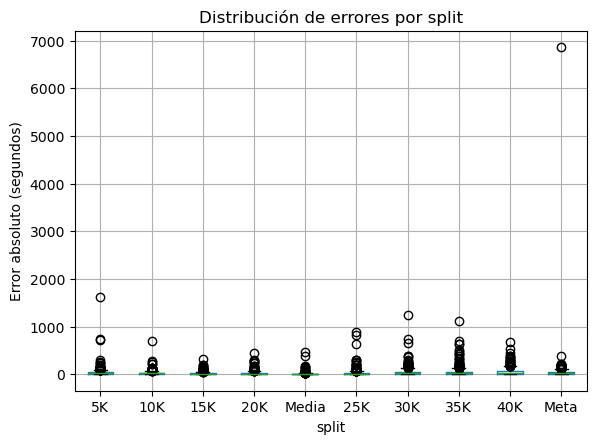

<Figure size 800x500 with 0 Axes>

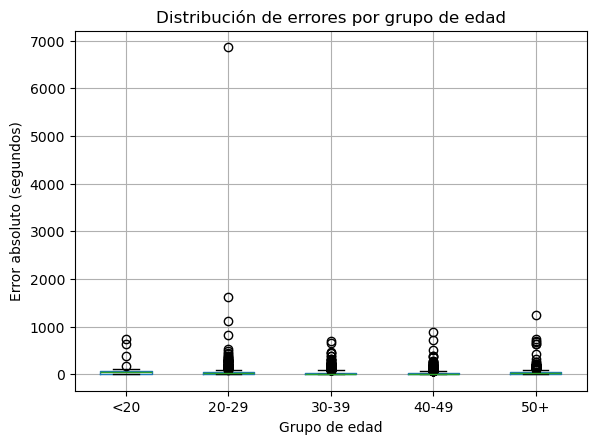

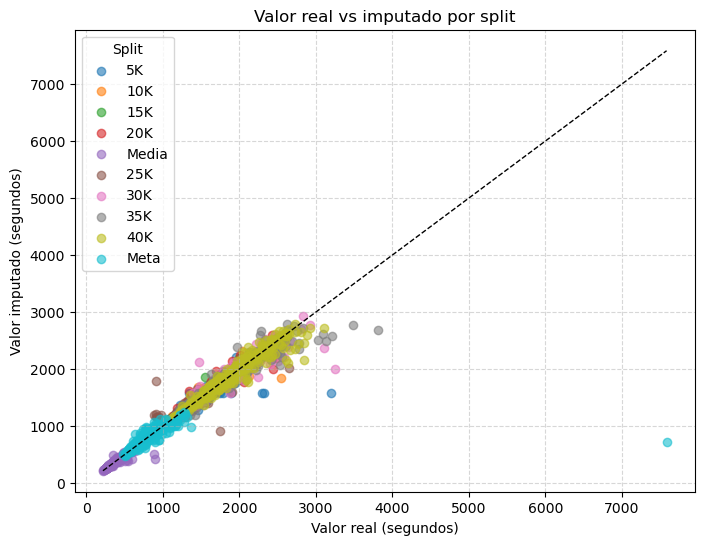

In [9]:
mae_scaled, mae_seconds, examples_min, mae_per_split, df_wide, comparison = imputacion_knn_maraton(
    athletes_events_df, athletes_time_df, athletes_df, nan_fraction=0.2, race_id_filter='49603c2f-1b2b-457f-b82e-fed8bded1d3d', event_std_filter='maraton'
)

In [11]:
from sklearn.metrics.pairwise import nan_euclidean_distances
import pandas as pd

def analisis_mal_imputado(df_wide, comparison):
    """
    Analiza splits mal imputados y genera:
    - df_mal: splits con error >10%
    - df_comparacion: información completa de splits, z-score, vecinos, edad/género
    - Grupos de error: >10%, >25%, >50%, >100% (inclusivos)
    """
    df = comparison.copy()
    
    umbrales = [0.1, 0.25, 0.5, 1.0] 
    for u in umbrales:
        col_name = f'error_mayor_{int(u*100)}%'
        df[col_name] = df['abs_error'] > (u * df['valor_real'])
    
    df_splits = df.pivot_table(index='athlete_id', columns='split', values='valor_real')
    atletas_info = df.groupby('athlete_id')[['age','gender']].first()
    df_features = pd.concat([df_splits, atletas_info], axis=1)
    
    df_comparacion = []
    for split in df_splits.columns:
        mean_split = df_splits[split].mean()
        std_split = df_splits[split].std()
        temp = pd.DataFrame({
            'athlete_id': df_splits.index,
            'split': split,
            'valor_real': df_splits[split],
            'mean_split_otros': mean_split,
            'std_split_otros': std_split,
            'z_score_split': (df_splits[split] - mean_split) / std_split
        })
        df_comparacion.append(temp)
    df_comparacion = pd.concat(df_comparacion, ignore_index=True)
    
    dist_matrix = nan_euclidean_distances(df_features)
    dist_df = pd.DataFrame(dist_matrix, index=df_features.index, columns=df_features.index)
    threshold = 0.5
    vecinos_cercanos = (dist_df < threshold).sum(axis=1) - 1
    df_comparacion = df_comparacion.merge(vecinos_cercanos.rename('num_vecinos_cercanos'), on='athlete_id', how='left')
    
    df_comparacion = df_comparacion.merge(atletas_info, left_on='athlete_id', right_index=True, how='left')
    df_mal = df[df['error_mayor_10%']].copy()
    
    return df_mal, df_comparacion

In [12]:
df_mal, df_comparacion = analisis_mal_imputado(df_wide, comparison)

C:\Users\mario\AppData\Local\Temp\ipykernel_17184\3954818223.py:18: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_splits = df.pivot_table(index='athlete_id', columns='split', values='valor_real')


In [13]:
grupos_mal = {
    '≥10%': df_mal[df_mal['error_mayor_10%']]['athlete_id'].unique(),
    '≥25%': df_mal[df_mal['error_mayor_25%']]['athlete_id'].unique(),
    '≥50%': df_mal[df_mal['error_mayor_50%']]['athlete_id'].unique(),
    '≥100%': df_mal[df_mal['error_mayor_100%']]['athlete_id'].unique()
}

for grupo, atletas in grupos_mal.items():
    n_atletas = len(atletas)
    print(f'Grupo {grupo}: {n_atletas} atletas')

Grupo ≥10%: 171 atletas
Grupo ≥25%: 24 atletas
Grupo ≥50%: 4 atletas
Grupo ≥100%: 0 atletas


In [14]:
comparison['fue_imputado'] = comparison['abs_error'] > 0

atletas_bien_imputados = comparison[(comparison['fue_imputado']) & 
                                    (comparison['abs_error'] <= 0.1 * comparison['valor_real'])]['athlete_id'].unique()

print("Número de atletas imputados con error ≤10%:", len(atletas_bien_imputados))

Número de atletas imputados con error ≤10%: 4101


In [15]:
import matplotlib.pyplot as plt

def graficar_curvas_error_imputacion(df_wide, df_mal, atletas_bien_imputados, figsize=(12,6), colores=None):
    """
    Grafica las curvas promedio de tiempos reales por grupo de error de imputación.

    Parámetros:
    - df_wide: DataFrame con los tiempos reales por split (columnas de splits)
    - df_mal: DataFrame con los atletas mal imputados y sus errores
    - atletas_bien_imputados: lista o array con athlete_id de los bien imputados (<10%)
    - figsize: tupla con tamaño de la figura (default: (12,6))
    - colores: lista de colores para cada grupo (default: ['green','orange','red','purple','brown'])
    """
    
    if colores is None:
        colores = ['green', 'orange', 'red', 'purple', 'brown']
    
    splits_cols = [c for c in df_wide.columns if c not in ['athlete_id','race_id','event_id','gender','age']]
    
    grupos = {
        '<10%': atletas_bien_imputados,
        '≥10%': df_mal[df_mal['error_mayor_10%']]['athlete_id'].unique(),
        '≥25%': df_mal[df_mal['error_mayor_25%']]['athlete_id'].unique(),
        '≥50%': df_mal[df_mal['error_mayor_50%']]['athlete_id'].unique(),
        '≥100%': df_mal[df_mal['error_mayor_100%']]['athlete_id'].unique()
    }
    
    plt.figure(figsize=figsize)
    
    for i, (grupo, atletas) in enumerate(grupos.items()):
        if len(atletas) == 0:
            continue
        
        curvas = df_wide[df_wide['athlete_id'].isin(atletas)][splits_cols]
        
        if curvas.empty:
            continue
        
        curva_promedio = curvas.mean(axis=0)
        n_atletas = len(curvas)
        
        plt.plot(splits_cols, curva_promedio.values, color=colores[i], linewidth=2,
                 label=f'{grupo} (n={n_atletas})')
    
    plt.xlabel('Splits')
    plt.ylabel('Tiempo promedio (segundos)')
    plt.title('Curvas promedio de tiempos reales según error de imputación')
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.show()


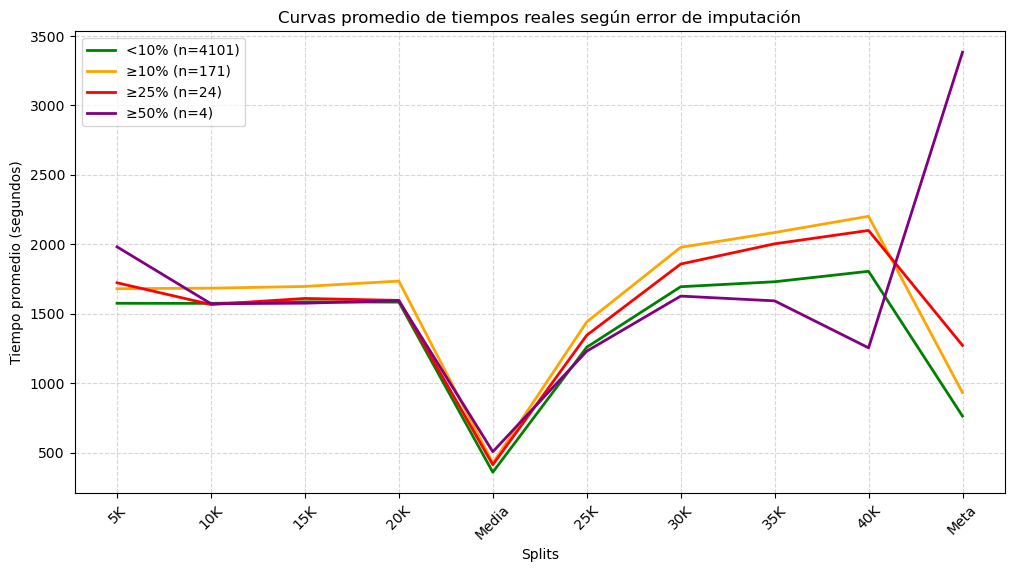

In [16]:
graficar_curvas_error_imputacion(df_wide, df_mal, atletas_bien_imputados)

### media

INFO: Filtrando eventos por splits completos y tipo de evento
INFO: Merge inicial para validación de splits
INFO: Merge de datos de tiempos y atletas
INFO: Filtrado por race_id=b228b93e-2a15-4123-baf9-ca0915165c6a, 131828 filas restantes
INFO: n_neighbors=5: MAE=37.62 seg
INFO: n_neighbors=10: MAE=34.95 seg
INFO: n_neighbors=15: MAE=33.80 seg
INFO: n_neighbors=20: MAE=33.15 seg
INFO: n_neighbors=25: MAE=32.74 seg
INFO: n_neighbors=30: MAE=32.50 seg
INFO: n_neighbors=50: MAE=31.97 seg
INFO: n_neighbors=100: MAE=31.76 seg
INFO: n_neighbors=200: MAE=32.05 seg
INFO: Mejor n_neighbors=100 con MAE=31.76 seg
C:\Users\mario\AppData\Local\Temp\ipykernel_17184\3621687622.py:137: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  comparison = pd.concat([co

<Figure size 800x500 with 0 Axes>

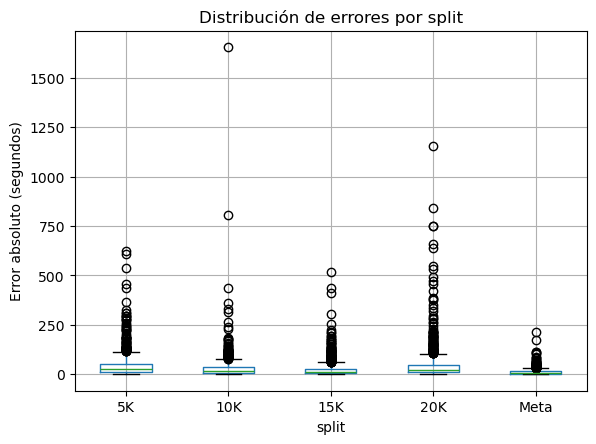

<Figure size 800x500 with 0 Axes>

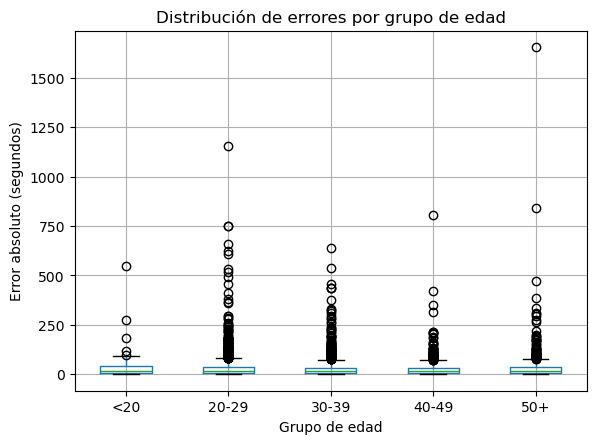

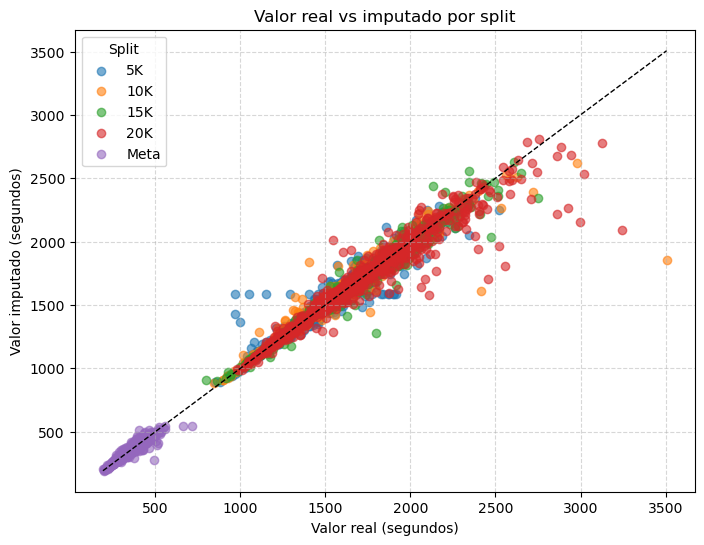

In [17]:
mae_scaled, mae_seconds, examples_min, mae_per_split, df_wide, comparison = imputacion_knn_maraton(
    athletes_events_df, athletes_time_df, athletes_df, nan_fraction=0.2, race_id_filter='b228b93e-2a15-4123-baf9-ca0915165c6a', event_std_filter='media'
)

In [26]:
df_mal, df_comparacion = analisis_mal_imputado(df_wide, comparison)

C:\Users\mario\AppData\Local\Temp\ipykernel_17184\3954818223.py:18: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_splits = df.pivot_table(index='athlete_id', columns='split', values='valor_real')


In [27]:
grupos_mal = {
    '≥10%': df_mal[df_mal['error_mayor_10%']]['athlete_id'].unique(),
    '≥25%': df_mal[df_mal['error_mayor_25%']]['athlete_id'].unique(),
    '≥50%': df_mal[df_mal['error_mayor_50%']]['athlete_id'].unique(),
    '≥100%': df_mal[df_mal['error_mayor_100%']]['athlete_id'].unique()
}

for grupo, atletas in grupos_mal.items():
    n_atletas = len(atletas)
    print(f'Grupo {grupo}: {n_atletas} atletas')

Grupo ≥10%: 141 atletas
Grupo ≥25%: 18 atletas
Grupo ≥50%: 3 atletas
Grupo ≥100%: 0 atletas


In [28]:
comparison['fue_imputado'] = comparison['abs_error'] > 0

atletas_bien_imputados = comparison[(comparison['fue_imputado']) & 
                                    (comparison['abs_error'] <= 0.1 * comparison['valor_real'])]['athlete_id'].unique()

print("Número de atletas imputados con error ≤10%:", len(atletas_bien_imputados))

Número de atletas imputados con error ≤10%: 5169


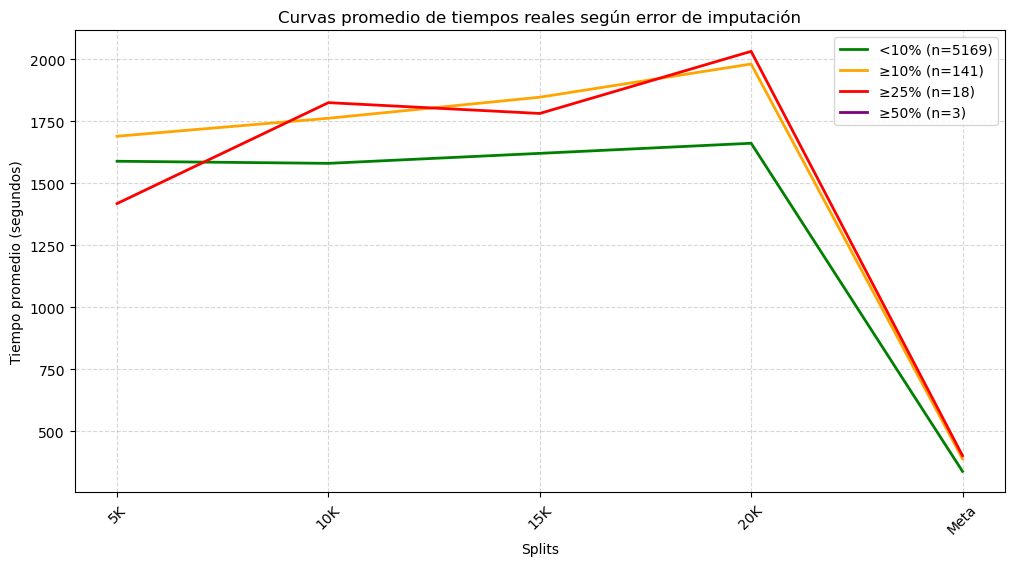

In [20]:
graficar_curvas_error_imputacion(df_wide, df_mal, atletas_bien_imputados)

In [29]:
splits_cols = [c for c in df_wide.columns if c not in ['athlete_id','race_id','event_id','gender','age']]
promedio_real = df_wide.set_index('athlete_id')[splits_cols].mean(axis=1)

In [33]:
mejores_200 = promedio_real.nsmallest(200)
mejores_ids = mejores_200.index

In [34]:
grupos_error = {
    '<10%': set(atletas_bien_imputados),
    '≥10%': set(df_mal[df_mal['error_mayor_10%']]['athlete_id'].unique()),
    '≥25%': set(df_mal[df_mal['error_mayor_25%']]['athlete_id'].unique()),
    '≥50%': set(df_mal[df_mal['error_mayor_50%']]['athlete_id'].unique()),
    '≥100%': set(df_mal[df_mal['error_mayor_100%']]['athlete_id'].unique())
}

In [35]:
conteo_mejores = {}
for grupo, atletas in grupos_error.items():
    conteo_mejores[grupo] = len(atletas.intersection(mejores_ids))

conteo_mejores

{'<10%': 42, '≥10%': 1, '≥25%': 0, '≥50%': 0, '≥100%': 0}

In [36]:
tiempo_total = df_wide.set_index('athlete_id')[splits_cols].sum(axis=1)

atletas_imputados = df_mal['athlete_id'].unique()
tiempo_total_imputados = tiempo_total.loc[tiempo_total.index.isin(atletas_imputados)]

mejor_atleta_id = tiempo_total_imputados.idxmin()
mejor_atleta_tiempo = tiempo_total_imputados.min()

errores_mejor_atleta = df_mal[df_mal['athlete_id'] == mejor_atleta_id][['split','valor_real','valor_imputado','abs_error']]

print(f"Atleta más rápido imputado: {mejor_atleta_id}")
print(f"Tiempo total real: {mejor_atleta_tiempo:.2f} segundos")
print("Errores de imputación por split:")
print(errores_mejor_atleta)


Atleta más rápido imputado: Y4Y349F3
Tiempo total real: 967.13 segundos
Errores de imputación por split:
    split  valor_real  valor_imputado   abs_error
994    5K     967.127     1589.647066  622.520066


## Ajuste temporal

In [45]:

logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

def extraer_datos_splits_completos(
    athletes_events_df, athletes_time_df, athletes_df,
    race_id_filter=None, event_std_filter='media'
):
    """
    Extrae splits completos y muestra columnas en cada DataFrame.
    """
    logging.info("=== athletes_events_df columnas ===")
    print(athletes_events_df.columns.tolist())

    logging.info("Filtrando eventos por splits completos y tipo de evento")
    filtered_events = athletes_events_df[
        (athletes_events_df['splitsMissing'] == 0) &
        (athletes_events_df['maxConsecutiveSplitsMissing'] == 0) &
        (athletes_events_df['event_std'] == event_std_filter)
    ][['athlete_id', 'event_id', 'event_std', 'race_id']]
    logging.info("=== filtered_events columnas ===")
    print(filtered_events.columns.tolist())

    logging.info("Merge inicial para obtener tiempos y splits")
    df_merged = athletes_time_df.merge(filtered_events, on=['athlete_id', 'event_id', 'race_id', 'event_std'], how='inner')
    logging.info("=== df_merged columnas después del merge con filtered_events ===")
    print(df_merged.columns.tolist())

    df_merged = df_merged.merge(athletes_df[['athlete_id', 'birthdate', 'gender']], on=['athlete_id'], how='left')
    logging.info("=== df_merged columnas después del merge con athletes_df ===")
    print(df_merged.columns.tolist())

    if race_id_filter is not None:
        if 'race_id' in df_merged.columns:
            df_merged = df_merged[df_merged['race_id'] == race_id_filter].copy()
            logging.info(f"Filtrado por race_id={race_id_filter}, filas restantes: {len(df_merged)}")
        else:
            logging.warning("'race_id' no encontrado en df_merged, se omite filtrado")

    cols_to_keep = ['athlete_id', 'event_id', 'race_id', 'split', 'time_split_sec', 'gender', 'birthdate']
    df_subset = df_merged[[c for c in cols_to_keep if c in df_merged.columns]].copy()
    logging.info("=== df_subset columnas ===")
    print(df_subset.columns.tolist())

    df_subset = df_subset[df_subset['split'] != 'Salida'].dropna(subset=['time_split_sec', 'birthdate'])
    logging.info("=== df_subset columnas después de filtrar 'Salida' y NA ===")
    print(df_subset.columns.tolist())

    index_cols = ['athlete_id', 'event_id']
    if 'race_id' in df_subset.columns:
        index_cols.insert(1, 'race_id')
    df_wide = df_subset.pivot_table(
        index=index_cols,
        columns='split',
        values='time_split_sec'
    ).reset_index()
    logging.info("=== df_wide columnas después del pivot ===")
    print(df_wide.columns.tolist())

    df_subset['birthdate'] = pd.to_datetime(df_subset['birthdate'])
    df_subset['race_date'] = pd.to_datetime(df_subset.get('race_date', pd.Timestamp.today()))
    athletes_info = df_subset.groupby('athlete_id').first()[['gender', 'birthdate', 'race_date']].reset_index()
    athletes_info['age'] = (athletes_info['race_date'] - athletes_info['birthdate']).dt.days / 365.25
    athletes_info['gender'] = athletes_info['gender'].map({'male': 0, 'female': 1})

    df_wide = df_wide.merge(athletes_info[['athlete_id', 'gender', 'age']], on='athlete_id', how='left')
    logging.info("=== df_wide columnas después de merge con edad y gender ===")

    df_wide_clean = df_wide.dropna()

    logging.info("Datos listos para clustering")
    return df_wide_clean

In [46]:
df_subset = athletes_events_df[
    (athletes_events_df['race_id'] == 'b228b93e-2a15-4123-baf9-ca0915165c6a') &
    (athletes_events_df['event_id'] == 'Mitja')
]

max_splits = df_subset['splitsSeen'].max()

df_filtered = df_subset[
    (df_subset['splitsMissing'] == 0) &
    (df_subset['maxConsecutiveSplitsMissing'] == 0) &
    (df_subset['splitsSeen'] < max_splits)
]

df_filtered[['athlete_id', 'event_id', 'race_id', 'splitsMissing', 'maxConsecutiveSplitsMissing', 'splitsSeen', 'last_split_seen']].head(5)

,athlete_id,event_id,race_id,splitsMissing,maxConsecutiveSplitsMissing,splitsSeen,last_split_seen
0,31,Mitja,b228b93e-2a15-4123-baf9-ca0915165c6a,0,0,2,5K
5,193,Mitja,b228b93e-2a15-4123-baf9-ca0915165c6a,0,0,0,notstarted
6,194,Mitja,b228b93e-2a15-4123-baf9-ca0915165c6a,0,0,0,notstarted
16,C29C3BY4,Mitja,b228b93e-2a15-4123-baf9-ca0915165c6a,0,0,0,notstarted
26,75YYC4C5,Mitja,b228b93e-2a15-4123-baf9-ca0915165c6a,0,0,0,notstarted


In [47]:
"""
Extrae splits completos y muestra columnas en cada DataFrame.
"""
logging.info("=== athletes_events_df columnas ===")
print(athletes_events_df.columns.tolist())

logging.info("Filtrando eventos por splits completos y tipo de evento")
filtered_events = athletes_events_df[
    (athletes_events_df['splitsMissing'] == 0) &
    (athletes_events_df['maxConsecutiveSplitsMissing'] == 0) &
    (athletes_events_df['event_std'] == 'media')
][['athlete_id', 'event_id', 'event_std', 'race_id']]
logging.info("=== filtered_events columnas ===")
print(filtered_events.columns.tolist())

logging.info("Merge inicial para obtener tiempos y splits")
df_merged = athletes_time_df.merge(filtered_events, on=['athlete_id', 'event_id', 'race_id', 'event_std'], how='inner')
logging.info("=== df_merged columnas después del merge con filtered_events ===")
print(df_merged.columns.tolist())

df_merged = df_merged.merge(athletes_df[['athlete_id', 'birthdate', 'gender']], on=['athlete_id'], how='left')
logging.info("=== df_merged columnas después del merge con athletes_df ===")
print(df_merged.columns.tolist())

if '2fa6d70a-afef-4f4e-880e-deea01248d9b' is not None:
    if 'race_id' in df_merged.columns:
        df_merged = df_merged[df_merged['race_id'] == 'b228b93e-2a15-4123-baf9-ca0915165c6a'].copy()
        logging.info(f"Filtrado por race_id={'b228b93e-2a15-4123-baf9-ca0915165c6a'}, filas restantes: {len(df_merged)}")
    else:
        logging.warning("'race_id' no encontrado en df_merged, se omite filtrado")

cols_to_keep = ['athlete_id', 'event_id', 'race_id', 'split', 'time_split_sec', 'gender', 'birthdate']
df_subset = df_merged[[c for c in cols_to_keep if c in df_merged.columns]].copy()
logging.info("=== df_subset columnas ===")
print(df_subset.columns.tolist())

df_subset = df_subset[df_subset['split'] != 'Salida'].dropna(subset=['time_split_sec', 'birthdate'])
logging.info("=== df_subset columnas después de filtrar 'Salida' y NA ===")
print(df_subset.columns.tolist())

index_cols = ['athlete_id', 'event_id', 'race_id']
df_wide = df_subset.pivot_table(
    index=index_cols,
    columns='split',
    values='time_split_sec'
).reset_index()
logging.info("=== df_wide columnas después del pivot ===")
print(df_wide.columns.tolist())

<>:25: SyntaxWarning: "is not" with 'str' literal. Did you mean "!="?
<>:25: SyntaxWarning: "is not" with 'str' literal. Did you mean "!="?
INFO: === athletes_events_df columnas ===
INFO: Filtrando eventos por splits completos y tipo de evento
INFO: === filtered_events columnas ===
INFO: Merge inicial para obtener tiempos y splits


['athlete_id', 'auto_category', 'auto_chip', 'category', 'distance', 'dorsal', 'event_id', 'gunTime', 'gunTimeMode', 'gunTimeModeConfig_wave', 'last_split_seen', 'maxConsecutiveSplitsMissing', 'race_id', 'realStatus', 'splitsMissing', 'splitsSeen', 'startNetTime', 'startRawTime', 'startTime', 'status', 'team', 'event_std', 'startNetTime_td', 'startTime_td']
['athlete_id', 'event_id', 'event_std', 'race_id']


INFO: === df_merged columnas después del merge con filtered_events ===
INFO: === df_merged columnas después del merge con athletes_df ===
C:\Users\mario\AppData\Local\Temp\ipykernel_17184\812590126.py:25: SyntaxWarning: "is not" with 'str' literal. Did you mean "!="?
  if '2fa6d70a-afef-4f4e-880e-deea01248d9b' is not None:


['athlete_id', 'average', 'distance', 'event_id', 'incidence', 'isBackup', 'netTime', 'offset', 'order', 'race_id', 'rawTime', 'split', 'time', 'event_std', 'netTime_td', 'time_td', 'time_split_sec', 'prev_split', 'split_order']
['athlete_id', 'average', 'distance', 'event_id', 'incidence', 'isBackup', 'netTime', 'offset', 'order', 'race_id', 'rawTime', 'split', 'time', 'event_std', 'netTime_td', 'time_td', 'time_split_sec', 'prev_split', 'split_order', 'birthdate', 'gender']


INFO: Filtrado por race_id=b228b93e-2a15-4123-baf9-ca0915165c6a, filas restantes: 158557
INFO: === df_subset columnas ===
INFO: === df_subset columnas después de filtrar 'Salida' y NA ===


['athlete_id', 'event_id', 'race_id', 'split', 'time_split_sec', 'gender', 'birthdate']
['athlete_id', 'event_id', 'race_id', 'split', 'time_split_sec', 'gender', 'birthdate']


INFO: === df_wide columnas después del pivot ===


['athlete_id', 'event_id', 'race_id', '10K', '15K', '20K', '5K', 'Meta']


In [48]:
df_subset['birthdate'] = pd.to_datetime(df_subset['birthdate'])
df_subset['race_date'] = pd.to_datetime(df_subset.get('race_date', pd.Timestamp.today()))
athletes_info = df_subset.groupby('athlete_id').first()[['gender', 'birthdate', 'race_date']].reset_index()
athletes_info['age'] = (athletes_info['race_date'] - athletes_info['birthdate']).dt.days / 365.25
athletes_info['gender'] = athletes_info['gender'].map({'male': 0, 'female': 1})

df_wide = df_wide.merge(athletes_info[['athlete_id', 'gender', 'age']], on='athlete_id', how='left')
logging.info("=== df_wide columnas después de merge con edad y gender ===")

INFO: === df_wide columnas después de merge con edad y gender ===


In [50]:
df_wide = extraer_datos_splits_completos(athletes_events_df, athletes_time_df, athletes_df,
    race_id_filter='b228b93e-2a15-4123-baf9-ca0915165c6a', event_std_filter='media')

INFO: === athletes_events_df columnas ===
INFO: Filtrando eventos por splits completos y tipo de evento
INFO: === filtered_events columnas ===
INFO: Merge inicial para obtener tiempos y splits


['athlete_id', 'auto_category', 'auto_chip', 'category', 'distance', 'dorsal', 'event_id', 'gunTime', 'gunTimeMode', 'gunTimeModeConfig_wave', 'last_split_seen', 'maxConsecutiveSplitsMissing', 'race_id', 'realStatus', 'splitsMissing', 'splitsSeen', 'startNetTime', 'startRawTime', 'startTime', 'status', 'team', 'event_std', 'startNetTime_td', 'startTime_td']
['athlete_id', 'event_id', 'event_std', 'race_id']


INFO: === df_merged columnas después del merge con filtered_events ===
INFO: === df_merged columnas después del merge con athletes_df ===


['athlete_id', 'average', 'distance', 'event_id', 'incidence', 'isBackup', 'netTime', 'offset', 'order', 'race_id', 'rawTime', 'split', 'time', 'event_std', 'netTime_td', 'time_td', 'time_split_sec', 'prev_split', 'split_order']
['athlete_id', 'average', 'distance', 'event_id', 'incidence', 'isBackup', 'netTime', 'offset', 'order', 'race_id', 'rawTime', 'split', 'time', 'event_std', 'netTime_td', 'time_td', 'time_split_sec', 'prev_split', 'split_order', 'birthdate', 'gender']


INFO: Filtrado por race_id=b228b93e-2a15-4123-baf9-ca0915165c6a, filas restantes: 158557
INFO: === df_subset columnas ===
INFO: === df_subset columnas después de filtrar 'Salida' y NA ===
INFO: === df_wide columnas después del pivot ===


['athlete_id', 'event_id', 'race_id', 'split', 'time_split_sec', 'gender', 'birthdate']
['athlete_id', 'event_id', 'race_id', 'split', 'time_split_sec', 'gender', 'birthdate']
['athlete_id', 'race_id', 'event_id', '10K', '15K', '20K', '5K', 'Meta']


INFO: === df_wide columnas después de merge con edad y gender ===
INFO: Datos listos para clustering


In [51]:
df_wide.head(5)

,athlete_id,race_id,event_id,10K,15K,20K,5K,Meta,gender,age
0,1111B6ZY,b228b93e-2a15-4123-baf9-ca0915165c6a,Mitja,1633.132,1625.279,1625.978,1594.475,325.888,0.0,34.056126
1,1118BZ53,b228b93e-2a15-4123-baf9-ca0915165c6a,Mitja,1395.566,1382.856,1401.240,1393.216,287.454,0.0,36.695414
2,111CC3F8,b228b93e-2a15-4123-baf9-ca0915165c6a,Mitja,1863.922,1862.845,1855.556,1904.496,381.822,1.0,38.291581
3,111CZ127,b228b93e-2a15-4123-baf9-ca0915165c6a,Mitja,1112.130,1134.049,1177.837,1118.088,258.167,0.0,29.327858
4,112BYA92,b228b93e-2a15-4123-baf9-ca0915165c6a,Mitja,1472.889,1470.094,1463.164,1521.806,299.681,0.0,48.342231


In [52]:
df_wide_with_nan = df_wide[df_wide.isna().any(axis=1)]
print(df_wide_with_nan)

Empty DataFrame
Columns: [athlete_id, race_id, event_id, 10K, 15K, 20K, 5K, Meta, gender, age]
Index: []


### KMeans

c:\Users\mario\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
c:\Users\mario\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
c:\Users\mario\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
c:\User

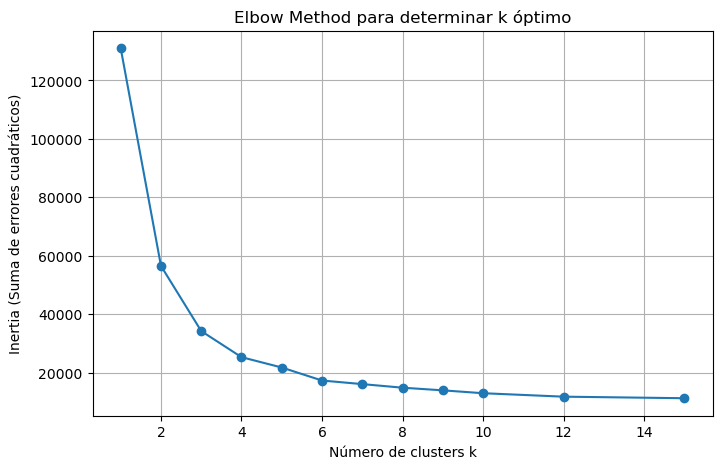

In [55]:

ordered_splits = ['5K', '10K', '15K', '20K', 'Meta']
X = df_wide[ordered_splits].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

k_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15]

inertia_values = []

for k in k_values:
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=1000)
    kmeans.fit(X_scaled)
    inertia_values.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(k_values, inertia_values, marker='o')
plt.xlabel('Número de clusters k')
plt.ylabel('Inertia (Suma de errores cuadráticos)')
plt.title('Elbow Method para determinar k óptimo')
plt.grid(True)
plt.show()


Filas después de eliminar outliers: 25159


c:\Users\mario\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


k=2, silhouette_score=0.5081


c:\Users\mario\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


k=3, silhouette_score=0.4600


c:\Users\mario\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


k=4, silhouette_score=0.4306


c:\Users\mario\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


k=5, silhouette_score=0.3882


c:\Users\mario\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


k=6, silhouette_score=0.3602


c:\Users\mario\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


k=7, silhouette_score=0.3516


c:\Users\mario\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


k=8, silhouette_score=0.3084


c:\Users\mario\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


k=9, silhouette_score=0.2956


c:\Users\mario\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


k=10, silhouette_score=0.2939


c:\Users\mario\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


k=12, silhouette_score=0.2733


c:\Users\mario\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


k=15, silhouette_score=0.2499

Mejor k según Silhouette: 2 (score=0.5081)

Centroides por cluster (tiempos en segundos):
            5K          10K          15K          20K        Meta
0  1744.230700  1736.751358  1784.656676  1836.705279  372.164406
1  1362.819965  1349.045427  1370.728034  1383.036246  283.075109


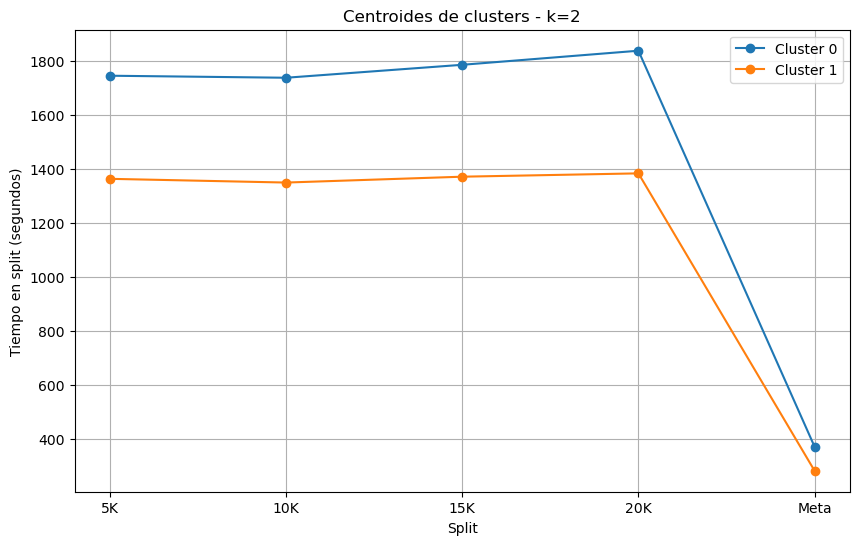

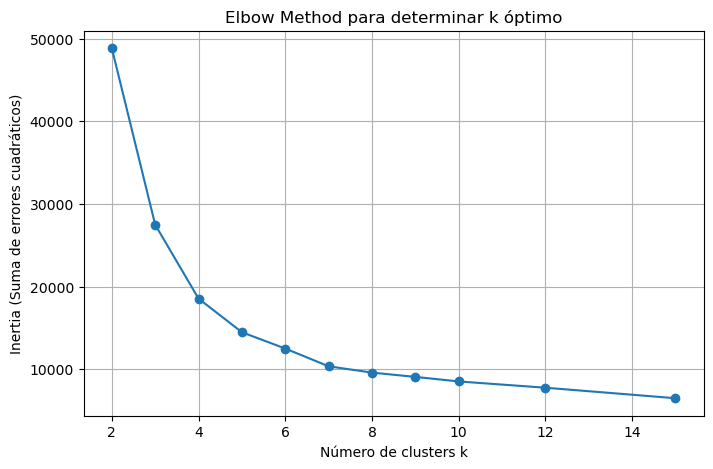

In [56]:

df_wide_clean = df_wide.copy()
for col in ordered_splits:
    q1 = df_wide_clean[col].quantile(0.25)
    q3 = df_wide_clean[col].quantile(0.75)
    iqr = q3 - q1
    upper_limit = q3 + 1.5 * iqr
    df_wide_clean = df_wide_clean[df_wide_clean[col] <= upper_limit]

print(f"Filas después de eliminar outliers: {len(df_wide_clean)}")

df_wide_clean[ordered_splits] = df_wide_clean[ordered_splits].apply(lambda x: np.log1p(x))

X = df_wide_clean[ordered_splits].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

k_values = [2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15]
best_score = -1
best_k = None
best_labels = None
best_model = None
inertia_values = []

for k in k_values:
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=1000)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    inertia_values.append(kmeans.inertia_)
    print(f"k={k}, silhouette_score={score:.4f}")
    
    if score > best_score:
        best_score = score
        best_k = k
        best_labels = labels
        best_model = kmeans

print(f"\nMejor k según Silhouette: {best_k} (score={best_score:.4f})")

df_wide_clean['cluster'] = best_labels

centroids_scaled = best_model.cluster_centers_
centroids_real = np.expm1(scaler.inverse_transform(centroids_scaled))
centroid_df = pd.DataFrame(centroids_real, columns=ordered_splits)
print("\nCentroides por cluster (tiempos en segundos):")
print(centroid_df)

plt.figure(figsize=(10,6))
for i, centroide in enumerate(centroids_real):
    plt.plot(ordered_splits, centroide, marker='o', label=f'Cluster {i}')
plt.xlabel("Split")
plt.ylabel("Tiempo en split (segundos)")
plt.title(f"Centroides de clusters - k={best_k}")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(k_values, inertia_values, marker='o')
plt.xlabel('Número de clusters k')
plt.ylabel('Inertia (Suma de errores cuadráticos)')
plt.title('Elbow Method para determinar k óptimo')
plt.grid(True)
plt.show()

Varianza explicada por PCA 1: 0.9523 (95.23%)
Varianza explicada por PCA 2: 0.0327 (3.27%)
Varianza acumulada 2 componentes: 0.9850 (98.50%)


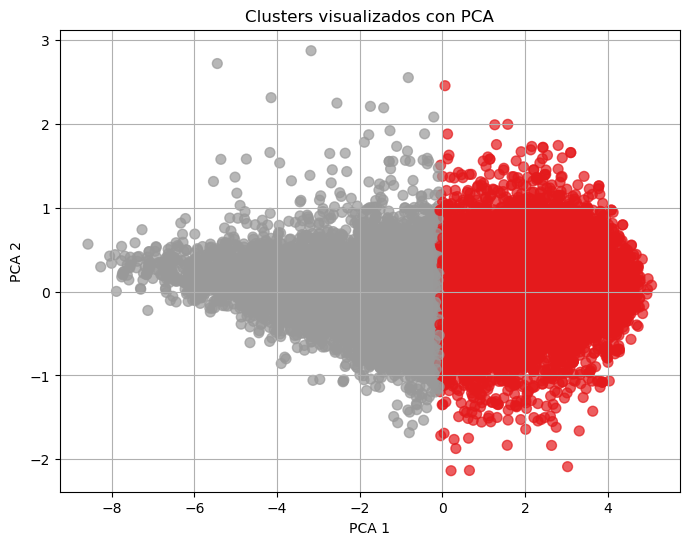

In [57]:

ordered_splits = ['5K', '10K', '15K', '20K', 'Meta']
X = df_wide_clean[ordered_splits].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

explained_variance = pca.explained_variance_ratio_
print(f"Varianza explicada por PCA 1: {explained_variance[0]:.4f} ({explained_variance[0]*100:.2f}%)")
print(f"Varianza explicada por PCA 2: {explained_variance[1]:.4f} ({explained_variance[1]*100:.2f}%)")
print(f"Varianza acumulada 2 componentes: {explained_variance.sum():.4f} ({explained_variance.sum()*100:.2f}%)")

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=df_wide_clean['cluster'], cmap='Set1', s=50, alpha=0.7)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Clusters visualizados con PCA')
plt.grid(True)
plt.show()


In [95]:
loadings = pd.DataFrame(pca.components_.T, index=ordered_splits, columns=['PCA1', 'PCA2'])
print(loadings)

          PCA1      PCA2
5K    0.442378 -0.573220
10K   0.450776 -0.362592
15K   0.453831 -0.057129
20K   0.449714  0.364170
Meta  0.439201  0.635659


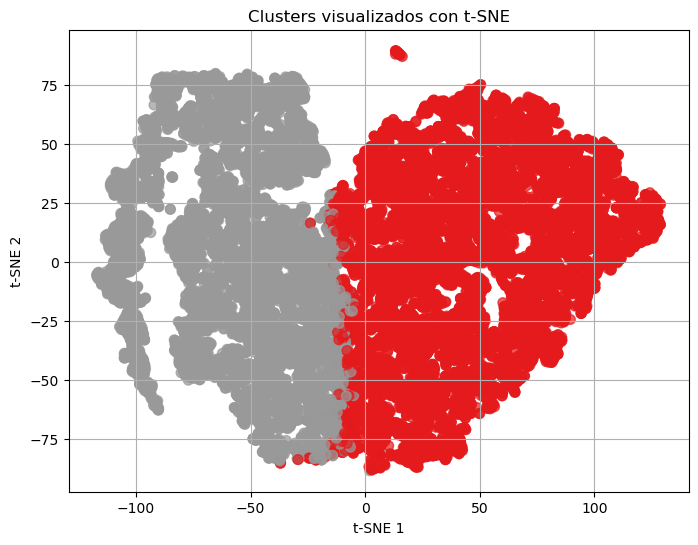

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42, perplexity=40, max_iter=1000)
X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=df_wide_clean['cluster'], cmap='Set1', s=50, alpha=0.7)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('Clusters visualizados con t-SNE')
plt.grid(True)
plt.show()

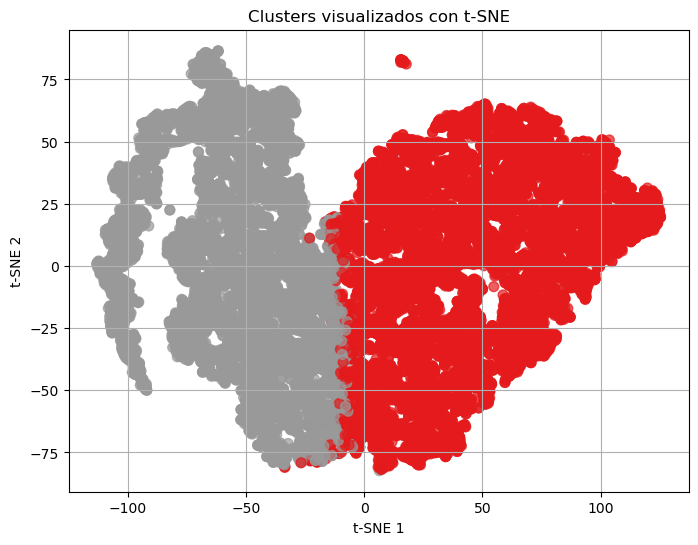

In [91]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42, perplexity=40, max_iter=1000)
X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=df_wide_clean['cluster'], cmap='Set1', s=50, alpha=0.7)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('Clusters visualizados con t-SNE')
plt.grid(True)
plt.show()

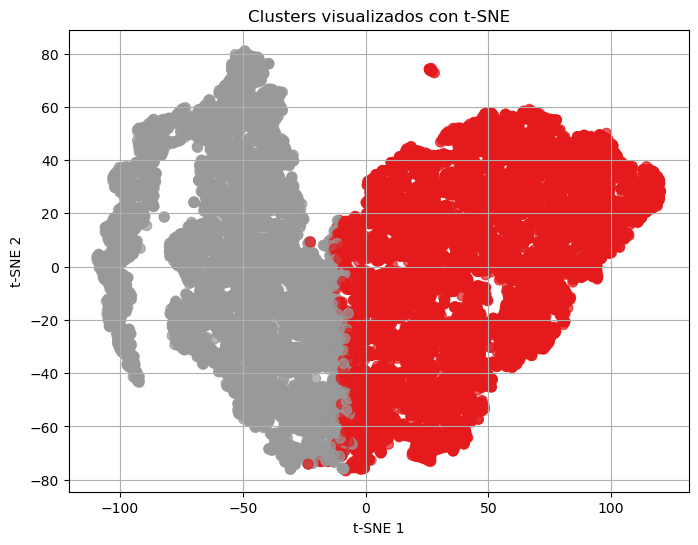

In [ ]:
tsne = TSNE(n_components=2, random_state=42, perplexity=50, max_iter=1000)
X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=df_wide_clean['cluster'], cmap='Set1', s=50, alpha=0.7)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('Clusters visualizados con t-SNE')
plt.grid(True)
plt.show()

### DBSCAN

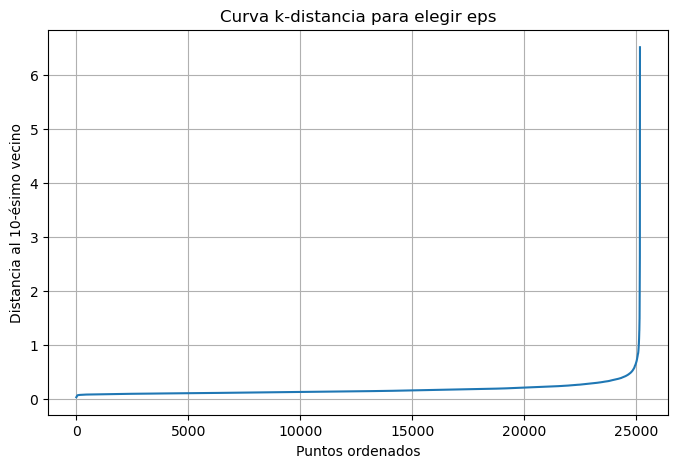

In [58]:
X = df_wide_clean[ordered_splits].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

k = 10
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

k_distances = np.sort(distances[:, k-1])

plt.figure(figsize=(8,5))
plt.plot(k_distances)
plt.xlabel("Puntos ordenados")
plt.ylabel(f"Distancia al {k}-ésimo vecino")
plt.title("Curva k-distancia para elegir eps")
plt.grid(True)
plt.show()

Número de clusters detectados: 1
Número de outliers: 67


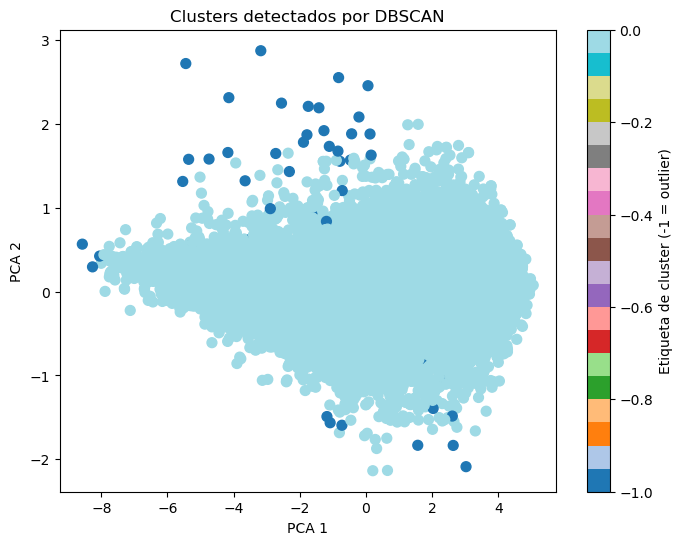

In [59]:
eps = 0.8
min_samples = 100

dbscan = DBSCAN(eps=eps, min_samples=min_samples)
dbscan_labels = dbscan.fit_predict(X_scaled)

df_wide_clean['dbscan_label'] = dbscan_labels

n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_outliers = list(dbscan_labels).count(-1)

print(f"Número de clusters detectados: {n_clusters}")
print(f"Número de outliers: {n_outliers}")

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=dbscan_labels, cmap='tab20', s=50)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Clusters detectados por DBSCAN")
plt.colorbar(label="Etiqueta de cluster (-1 = outlier)")
plt.show()

In [60]:
outliers = df_wide_clean[df_wide_clean['dbscan_label'] == -1]
inliers = df_wide_clean[df_wide_clean['dbscan_label'] != -1]

print(f"Número de outliers: {len(outliers)}")
print(f"Número de puntos en clusters: {len(inliers)}")

Número de outliers: 67
Número de puntos en clusters: 25092


In [61]:
print("---- Estadísticas de los puntos en clusters ----")
print(inliers[ordered_splits].describe())

print("\n---- Estadísticas de los outliers ----")
print(outliers[ordered_splits].describe())

---- Estadísticas de los puntos en clusters ----
                 5K           10K           15K           20K          Meta
count  25092.000000  25092.000000  25092.000000  25092.000000  25092.000000
mean       7.347303      7.339813      7.361492      7.381103      5.792012
std        0.159477      0.160950      0.167294      0.180420      0.176607
min        6.737797      6.730806      6.758764      6.760400      5.156143
25%        7.249141      7.241556      7.256516      7.263833      5.673079
50%        7.367621      7.356508      7.373620      7.387581      5.799024
75%        7.459876      7.450781      7.476688      7.506969      5.917859
max        7.726978      7.717779      7.750747      7.798116      6.204313

---- Estadísticas de los outliers ----
              5K        10K        15K        20K       Meta
count  67.000000  67.000000  67.000000  67.000000  67.000000
mean    7.155588   7.217819   7.306273   7.346086   5.711860
std     0.280629   0.321206   0.270436   0.2

C:\Users\mario\AppData\Local\Temp\ipykernel_17184\234799548.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([inliers[split] for split in ordered_splits], positions=np.arange(len(ordered_splits))*2-0.4, widths=0.6, labels=ordered_splits)
C:\Users\mario\AppData\Local\Temp\ipykernel_17184\234799548.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([outliers[split] for split in ordered_splits], positions=np.arange(len(ordered_splits))*2+0.4, widths=0.6, labels=ordered_splits)


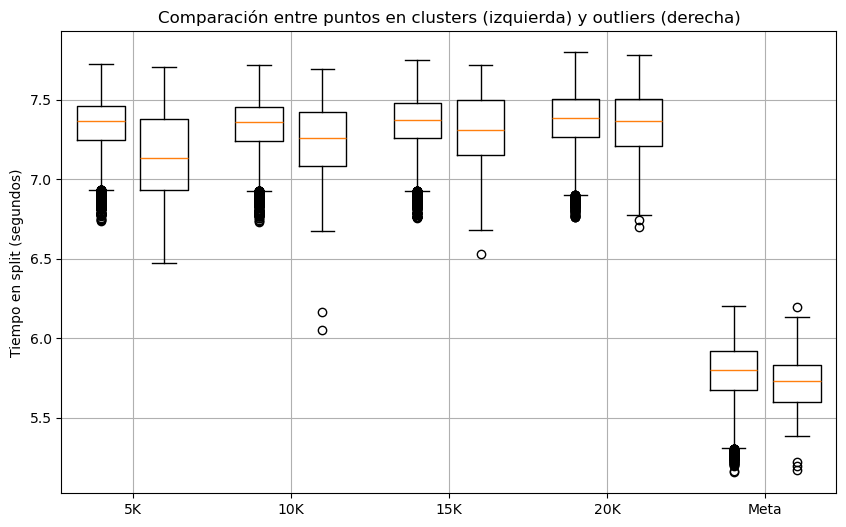

In [62]:
plt.figure(figsize=(10,6))
plt.boxplot([inliers[split] for split in ordered_splits], positions=np.arange(len(ordered_splits))*2-0.4, widths=0.6, labels=ordered_splits)
plt.boxplot([outliers[split] for split in ordered_splits], positions=np.arange(len(ordered_splits))*2+0.4, widths=0.6, labels=ordered_splits)
plt.xticks(np.arange(len(ordered_splits))*2, ordered_splits)
plt.ylabel("Tiempo en split (segundos)")
plt.title("Comparación entre puntos en clusters (izquierda) y outliers (derecha)")
plt.grid(True)
plt.show()

### pruebas

k=2, BIC=27927.33
k=3, BIC=10259.87
k=4, BIC=3884.53
k=5, BIC=1713.98
k=6, BIC=1829.56
k=7, BIC=1156.16
k=8, BIC=1137.90
k=9, BIC=698.47
k=10, BIC=248.29
k=12, BIC=689.12
k=15, BIC=358.21

Mejor k según BIC: 10


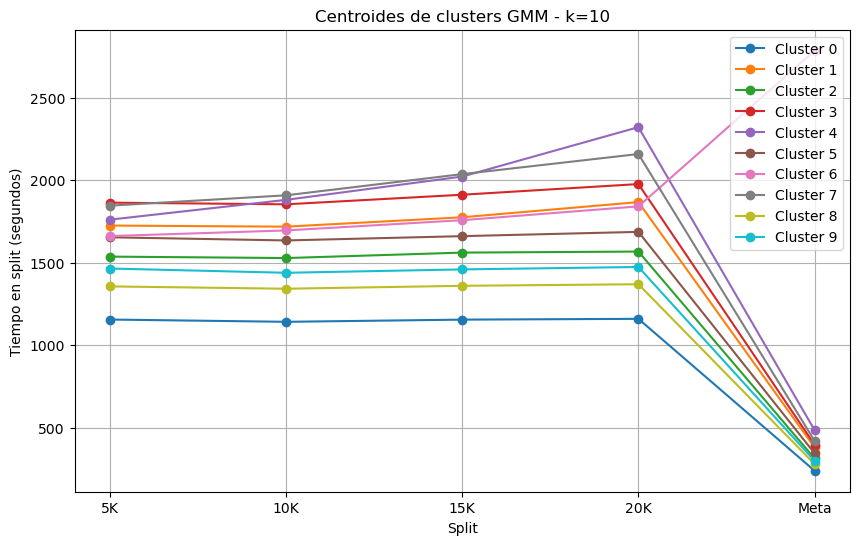

In [37]:
from sklearn.mixture import GaussianMixture
import numpy as np

k_values = [2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15]
lowest_bic = np.inf
best_gmm = None
bic_scores = []

for k in k_values:
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=42)
    gmm.fit(X_scaled)
    bic = gmm.bic(X_scaled)
    bic_scores.append(bic)
    print(f"k={k}, BIC={bic:.2f}")
    
    if bic < lowest_bic:
        lowest_bic = bic
        best_gmm = gmm

print(f"\nMejor k según BIC: {best_gmm.n_components}")

labels_gmm = best_gmm.predict(X_scaled)
df_wide['cluster_gmm'] = labels_gmm

probs_gmm = best_gmm.predict_proba(X_scaled)
centroids_gmm = scaler.inverse_transform(best_gmm.means_)

import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
for i, centroid in enumerate(centroids_gmm):
    plt.plot(split_cols, centroid, marker='o', label=f'Cluster {i}')
plt.xlabel("Split")
plt.ylabel("Tiempo en split (segundos)")
plt.title(f"Centroides de clusters GMM - k={best_gmm.n_components}")
plt.legend()
plt.grid(True)
plt.show()

Bandwidth estimado: 1.1979
Número de clusters encontrados: 49


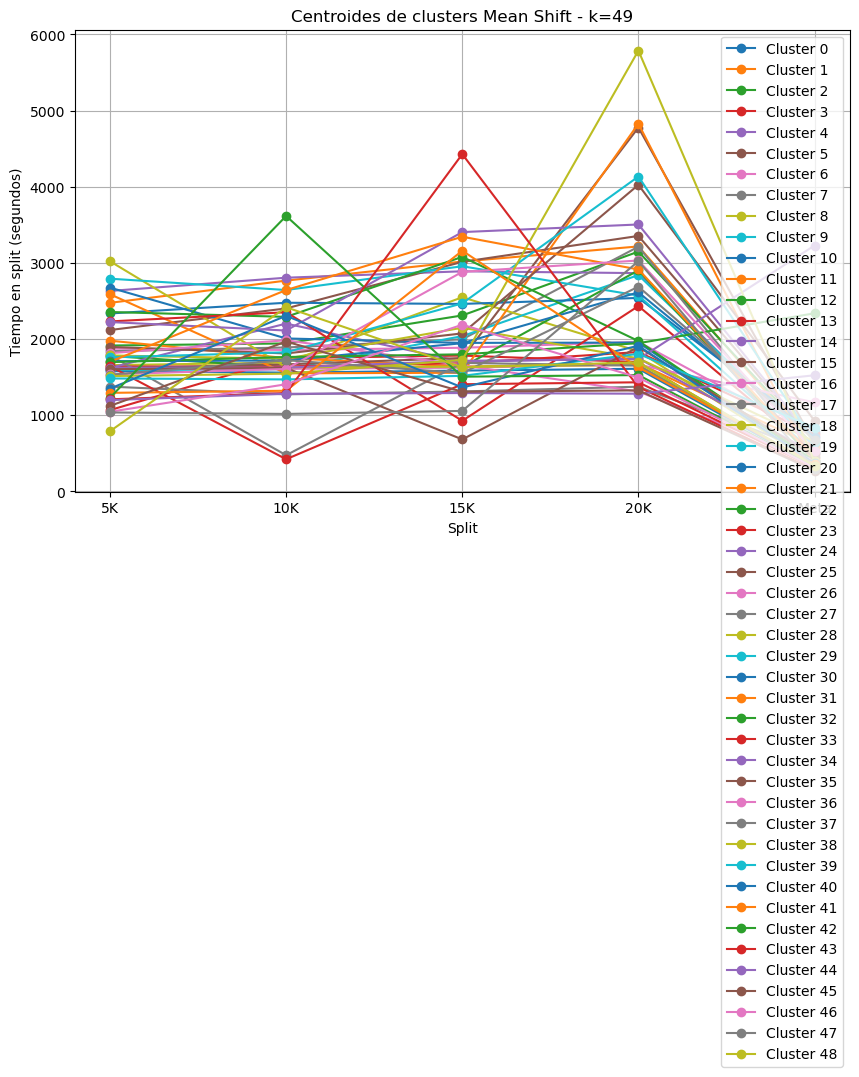

In [38]:
from sklearn.cluster import MeanShift, estimate_bandwidth
import matplotlib.pyplot as plt

bandwidth = estimate_bandwidth(X_scaled, quantile=0.2, n_samples=5000)
print(f"Bandwidth estimado: {bandwidth:.4f}")

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_scaled)

labels_ms = ms.labels_
cluster_centers = ms.cluster_centers_
n_clusters_ = len(np.unique(labels_ms))
print(f"Número de clusters encontrados: {n_clusters_}")

df_wide['cluster_meanshift'] = labels_ms

centroids_ms = scaler.inverse_transform(cluster_centers)

plt.figure(figsize=(10,6))
for i, centroid in enumerate(centroids_ms):
    plt.plot(split_cols, centroid, marker='o', label=f'Cluster {i}')
plt.xlabel("Split")
plt.ylabel("Tiempo en split (segundos)")
plt.title(f"Centroides de clusters Mean Shift - k={n_clusters_}")
plt.legend()
plt.grid(True)
plt.show()